# BERT-based Multi-Label Classification Model

This notebook implements a BERT-based model for multi-label classification of biomedical abstracts.
**Task:** Predict if an abstract provides evidence for therapeutic efficacy, side effects, or mechanism of action.

## Model: BioBERT or SciBERT with Multi-Label Classification Head
## Comparison: Performance vs Baseline TF-IDF + LogisticRegression

### Key Features:
- Pre-trained biomedical BERT model
- Multi-label classification with sigmoid activation
- Attention weight analysis
- Performance comparison with baseline

In [ ]:
# Install required packages if not already installed
# !pip install transformers torch torchvision torchaudio
# !pip install scikit-learn pandas numpy matplotlib seaborn
# !pip install tqdm

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, hamming_loss, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import joblib
from collections import defaultdict

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
import random
random.seed(42)

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Load the prepared data
df = pd.read_csv('../preprocessing/cleaned_for_modeling.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
df.head()

Dataset shape: (598, 15)
Columns: ['PMID', 'Title', 'Abstract', 'Journal', 'Year', 'Authors', 'Cleaned_Abstract', 'Categories', 'Research_Type', 'Diseases', 'Chemicals', 'Efficacy', 'Side_Effects', 'Mechanism', 'Has_Marketed_Drug']


,PMID,Title,Abstract,Journal,Year,Authors,Cleaned_Abstract,Categories,Research_Type,Diseases,Chemicals,Efficacy,Side_Effects,Mechanism,Has_Marketed_Drug
0,40603982,Barbigerone attenuates 3-nitropropionic acid-i...,"Huntington's Disease (HD), a neurodegenerative...",Scientific reports,2025.0,Sattam Khulaif Alenezi,huntington disease hd neurodegenerative diseas...,huntington's disease; hd; neurodegenerative di...,clinical_trial,huntington's disease; hd; neuroinflammation; m...,malondialdehyde; mda; nitric oxide; glutathion...,1,0,1,0
1,40590994,Comparative efficacy and safety of irreversibl...,"Parkinson's disease (PD) is a progressive, neu...",Journal of neurology,2025.0,Marwah Bintay Khalid; Faizan Shahzad; Momina R...,parkinson disease pd progressive neurodegenera...,parkinson's disease; pd; parkinson's disease r...,clinical_trial; review,parkinsons disease; parkinson's disease,safinamide; rasagiline; smd,1,1,1,1
2,40577046,Corticospinal Intermittent Theta Burst Stimula...,Intermittent theta burst stimulation (iTBS) is...,JMIR research protocols,2025.0,Deeksha Patel; Rohit Banerjee; Kamran Farooque...,intermittent theta burst stimulation itbs noni...,cord injury; motor and sensory dysfunction; as...,clinical_trial,cord injury; motor deficit; asia; pain; anxiet...,NaN,1,0,1,0
3,40572513,Advances in the Exploration of Coordination Co...,Alzheimer's disease (AD) is a progressive neur...,"Molecules (Basel, Switzerland)",2025.0,Jesús Antonio Cruz-Navarro; Luis Humberto Delg...,alzheimer disease ad progressive neurodegenera...,alzheimer's disease; ad; neurodegenerative dis...,review,alzheimers disease; memory disorder; amyloid-b...,NaN,1,1,1,0
4,40567829,How Do Patients' Fear Prediction and Fear Expe...,Expectancy violation has been proposed as a po...,Depression and anxiety,2025.0,Marina Hilleke; Thomas Lang; Sylvia Helbig-Lan...,expectancy violation propose potential core me...,anxiety; panic disorder; agoraphobia; panic; c...,clinical_trial,anxiety; panic attack; agoraphobia,NaN,1,1,1,0


In [7]:
# Check label distribution
print("Label Distribution:")
print(f"Efficacy: {df['Efficacy'].sum()} ({df['Efficacy'].mean()*100:.1f}%)")
print(f"Side_Effects: {df['Side_Effects'].sum()} ({df['Side_Effects'].mean()*100:.1f}%)")
print(f"Mechanism: {df['Mechanism'].sum()} ({df['Mechanism'].mean()*100:.1f}%)")

# Check marketed drug feature
print(f"\nAbstracts with marketed drugs: {df['Has_Marketed_Drug'].sum()} ({df['Has_Marketed_Drug'].mean()*100:.1f}%)")

# Check for missing values
print(f"\nMissing values:")
print(df[['Cleaned_Abstract', 'Has_Marketed_Drug', 'Efficacy', 'Side_Effects', 'Mechanism']].isnull().sum())

Label Distribution:
Efficacy: 584 (97.7%)
Side_Effects: 371 (62.0%)
Mechanism: 440 (73.6%)

Abstracts with marketed drugs: 119 (19.9%)

Missing values:
Cleaned_Abstract     0
Has_Marketed_Drug    0
Efficacy             0
Side_Effects         0
Mechanism            0
dtype: int64


In [8]:
# Prepare features and labels
X_text = df['Cleaned_Abstract'].fillna('')
X_drug = df['Has_Marketed_Drug'].values
y = df[['Efficacy', 'Side_Effects', 'Mechanism']].values

print(f"Text features shape: {X_text.shape}")
print(f"Drug features shape: {X_drug.shape}")
print(f"Labels shape: {y.shape}")

Text features shape: (598,)
Drug features shape: (598,)
Labels shape: (598, 3)


In [9]:
# Split the data (same as baseline for fair comparison)
X_text_train, X_text_test, X_drug_train, X_drug_test, y_train, y_test = train_test_split(
    X_text, X_drug, y, test_size=0.2, random_state=42, stratify=None
)

print(f"Training set size: {len(X_text_train)}")
print(f"Test set size: {len(X_text_test)}")

Training set size: 478
Test set size: 120


In [10]:
# Choose BERT model - try different options
MODEL_NAME = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"  # Good for biomedical abstracts

# Alternative models to try:
# "allenai/scibert_scivocab_uncased"  # SciBERT
# "dmis-lab/biobert-base-cased-v1.2"  # BioBERT
# "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"  # PubMedBERT (recommended)

print(f"Loading model: {MODEL_NAME}")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
bert_model = AutoModel.from_pretrained(MODEL_NAME)

# Check if tokenizer has padding token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print(f"Tokenizer vocab size: {tokenizer.vocab_size}")
print(f"Model hidden size: {bert_model.config.hidden_size}")

Loading model: microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract


2025-07-04 21:07:20.937406: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751659641.048492  277049 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751659641.068508  277049 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751659641.307341  277049 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751659641.307362  277049 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1751659641.307364  277049 computation_placer.cc:177] computation placer alr

Tokenizer vocab size: 28895
Model hidden size: 768


In [11]:
# Custom Dataset class for BERT
class BiomedicalDataset(Dataset):
    def __init__(self, texts, labels, drug_features, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.drug_features = drug_features
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts.iloc[idx])
        label = self.labels[idx]
        drug_feature = self.drug_features[idx]
        
        # Tokenize text
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label),
            'drug_feature': torch.FloatTensor([drug_feature])
        }

In [12]:
# BERT model with multi-label classification head
class BiomedicalBERTClassifier(nn.Module):
    def __init__(self, bert_model, num_labels=3, dropout=0.1):
        super(BiomedicalBERTClassifier, self).__init__()
        self.bert = bert_model
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(bert_model.config.hidden_size + 1, num_labels)  # +1 for drug feature
        
    def forward(self, input_ids, attention_mask, drug_feature):
        # Get BERT outputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output  # Use [CLS] token representation
        
        # Concatenate with drug feature
        combined_features = torch.cat([pooled_output, drug_feature], dim=1)
        
        # Apply dropout and classification
        pooled_output = self.dropout(combined_features)
        logits = self.classifier(pooled_output)
        
        return logits

# Initialize model
model = BiomedicalBERTClassifier(bert_model, num_labels=3)
model.to(device)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 109,484,550


In [13]:
# Create datasets and dataloaders
MAX_LENGTH = 512
BATCH_SIZE = 8  # Smaller batch size for BERT

# Create datasets
train_dataset = BiomedicalDataset(X_text_train, y_train, X_drug_train, tokenizer, MAX_LENGTH)
test_dataset = BiomedicalDataset(X_text_test, y_test, X_drug_test, tokenizer, MAX_LENGTH)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 60
Test batches: 15


In [14]:
# Training configuration
LEARNING_RATE = 2e-5
EPOCHS = 5
WARMUP_STEPS = 100

# Loss function for multi-label classification
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Learning rate scheduler
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=WARMUP_STEPS, 
    num_training_steps=total_steps
)

print(f"Total training steps: {total_steps}")
print(f"Warmup steps: {WARMUP_STEPS}")

Total training steps: 300
Warmup steps: 100


In [15]:
# Training function
def train_epoch(model, dataloader, optimizer, scheduler, criterion, device):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(dataloader, desc="Training")
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        drug_feature = batch['drug_feature'].to(device)
        
        optimizer.zero_grad()
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, drug_feature=drug_feature)
        loss = criterion(outputs, labels)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(dataloader)

# Evaluation function
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            drug_feature = batch['drug_feature'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, drug_feature=drug_feature)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            
            # Convert logits to probabilities and then to binary predictions
            probs = torch.sigmoid(outputs)
            predictions = (probs > 0.5).float()
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return total_loss / len(dataloader), np.array(all_predictions), np.array(all_labels)

In [16]:
# Training loop
print("Starting BERT training...")
train_losses = []
val_losses = []
best_f1 = 0
best_model_state = None

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch + 1}/{EPOCHS}")
    
    # Training
    train_loss = train_epoch(model, train_loader, optimizer, scheduler, criterion, device)
    train_losses.append(train_loss)
    
    # Evaluation
    val_loss, predictions, labels = evaluate_model(model, test_loader, criterion, device)
    val_losses.append(val_loss)
    
    # Calculate metrics
    micro_f1 = f1_score(labels, predictions, average='micro')
    macro_f1 = f1_score(labels, predictions, average='macro')
    hamming_loss_score = hamming_loss(labels, predictions)
    
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Micro F1: {micro_f1:.4f}")
    print(f"Macro F1: {macro_f1:.4f}")
    print(f"Hamming Loss: {hamming_loss_score:.4f}")
    
    # Save best model
    if micro_f1 > best_f1:
        best_f1 = micro_f1
        best_model_state = model.state_dict().copy()
        print(f"New best model! Micro F1: {best_f1:.4f}")

print("\nTraining completed!")

Starting BERT training...

Epoch 1/5


Evaluating: 100%|██████████| 15/15 [00:05<00:00,  2.99it/s]


Train Loss: 0.4907
Val Loss: 0.4048
Micro F1: 0.8899
Macro F1: 0.8838
Hamming Loss: 0.1972
New best model! Micro F1: 0.8899

Epoch 2/5


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.05it/s]


Train Loss: 0.3928
Val Loss: 0.3532
Micro F1: 0.9056
Macro F1: 0.8996
Hamming Loss: 0.1639
New best model! Micro F1: 0.9056

Epoch 3/5


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.04it/s]


Train Loss: 0.3234
Val Loss: 0.3353
Micro F1: 0.9060
Macro F1: 0.8956
Hamming Loss: 0.1556
New best model! Micro F1: 0.9060

Epoch 4/5


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.06it/s]


Train Loss: 0.2541
Val Loss: 0.3396
Micro F1: 0.8959
Macro F1: 0.8755
Hamming Loss: 0.1639

Epoch 5/5


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]

Train Loss: 0.1991
Val Loss: 0.3326
Micro F1: 0.9147
Macro F1: 0.9037
Hamming Loss: 0.1389
New best model! Micro F1: 0.9147

Training completed!


In [17]:
# Load best model and get final predictions
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with Micro F1: {best_f1:.4f}")

# Final evaluation
final_loss, final_predictions, final_labels = evaluate_model(model, test_loader, criterion, device)

# Calculate final metrics
bert_micro_f1 = f1_score(final_labels, final_predictions, average='micro')
bert_macro_f1 = f1_score(final_labels, final_predictions, average='macro')
bert_weighted_f1 = f1_score(final_labels, final_predictions, average='weighted')
bert_hamming_loss = hamming_loss(final_labels, final_predictions)

print("\n=== FINAL BERT MODEL RESULTS ===")
print(f"Micro F1: {bert_micro_f1:.4f}")
print(f"Macro F1: {bert_macro_f1:.4f}")
print(f"Weighted F1: {bert_weighted_f1:.4f}")
print(f"Hamming Loss: {bert_hamming_loss:.4f}")

# Per-label performance
labels = ['Efficacy', 'Side_Effects', 'Mechanism']
print("\n=== PER-LABEL PERFORMANCE ===")
for i, label in enumerate(labels):
    f1 = f1_score(final_labels[:, i], final_predictions[:, i], average='binary')
    precision = precision_score(final_labels[:, i], final_predictions[:, i], average='binary')
    recall = recall_score(final_labels[:, i], final_predictions[:, i], average='binary')
    print(f"{label}:")
    print(f"  F1: {f1:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  Support: {final_labels[:, i].sum()}")

Loaded best model with Micro F1: 0.9147


Evaluating: 100%|██████████| 15/15 [00:04<00:00,  3.08it/s]


=== FINAL BERT MODEL RESULTS ===
Micro F1: 0.9147
Macro F1: 0.9037
Weighted F1: 0.9154
Hamming Loss: 0.1389

=== PER-LABEL PERFORMANCE ===
Efficacy:
  F1: 0.9873
  Precision: 0.9750
  Recall: 1.0000
  Support: 117.0
Side_Effects:
  F1: 0.8148
  Precision: 0.7857
  Recall: 0.8462
  Support: 78.0
Mechanism:
  F1: 0.9091
  Precision: 0.8947
  Recall: 0.9239
  Support: 92.0


In [18]:
# Load baseline results for comparison
try:
    with open('baseline_results.json', 'r') as f:
        baseline_results = json.load(f)
    
    print("\n=== COMPARISON: BASELINE vs BERT ===")
    print(f"Baseline Micro F1: {baseline_results['micro_f1']:.4f}")
    print(f"BERT Micro F1: {bert_micro_f1:.4f}")
    print(f"Improvement: {bert_micro_f1 - baseline_results['micro_f1']:.4f}")
    
    print(f"\nBaseline Macro F1: {baseline_results['macro_f1']:.4f}")
    print(f"BERT Macro F1: {bert_macro_f1:.4f}")
    print(f"Improvement: {bert_macro_f1 - baseline_results['macro_f1']:.4f}")
    
    print(f"\nBaseline Hamming Loss: {baseline_results['hamming_loss']:.4f}")
    print(f"BERT Hamming Loss: {bert_hamming_loss:.4f}")
    print(f"Improvement: {baseline_results['hamming_loss'] - bert_hamming_loss:.4f}")
    
except FileNotFoundError:
    print("Baseline results not found. Run baseline model first for comparison.")


=== COMPARISON: BASELINE vs BERT ===
Baseline Micro F1: 0.8806
BERT Micro F1: 0.9147
Improvement: 0.0341

Baseline Macro F1: 0.8630
BERT Macro F1: 0.9037
Improvement: 0.0408

Baseline Hamming Loss: 0.1861
BERT Hamming Loss: 0.1389
Improvement: 0.0472


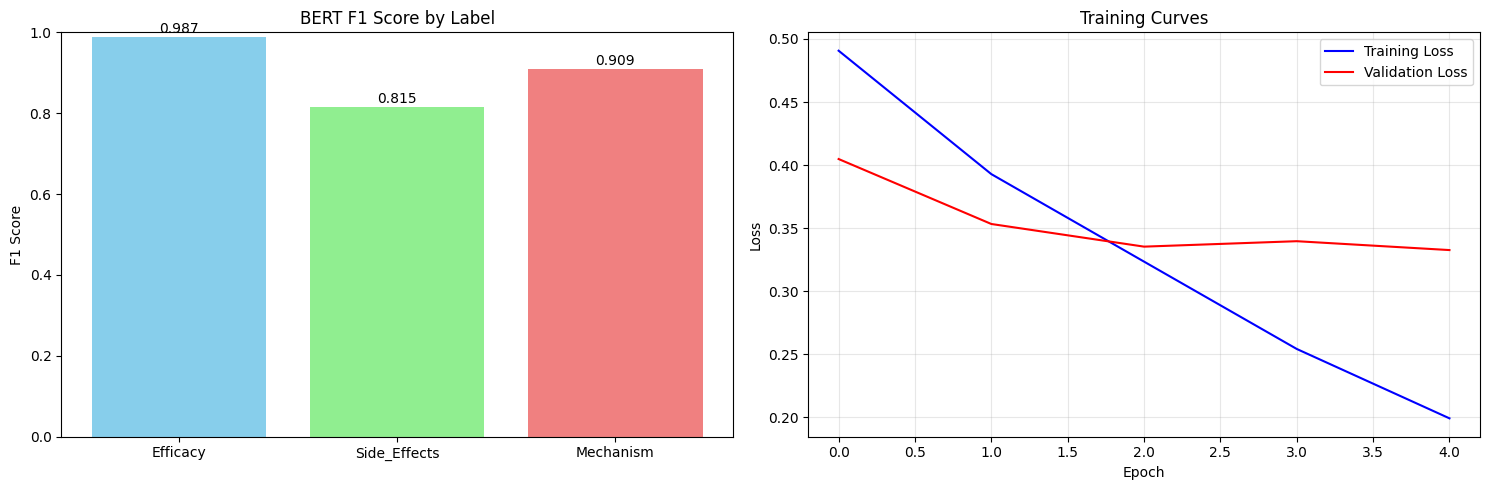

In [19]:
# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Per-label F1 scores
label_f1_scores = []
for i, label in enumerate(labels):
    f1 = f1_score(final_labels[:, i], final_predictions[:, i], average='binary')
    label_f1_scores.append(f1)

axes[0].bar(labels, label_f1_scores, color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_title('BERT F1 Score by Label')
axes[0].set_ylabel('F1 Score')
axes[0].set_ylim(0, 1)
for i, v in enumerate(label_f1_scores):
    axes[0].text(i, v + 0.01, f'{v:.3f}', ha='center')

# Training curves
axes[1].plot(train_losses, label='Training Loss', color='blue')
axes[1].plot(val_losses, label='Validation Loss', color='red')
axes[1].set_title('Training Curves')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [20]:
# Attention weight analysis (optional - for interpretability)
def get_attention_weights(model, tokenizer, text, drug_feature=0):
    """Get attention weights for a given text"""
    model.eval()
    
    # Tokenize
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=MAX_LENGTH,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    drug_feature_tensor = torch.FloatTensor([[drug_feature]]).to(device)
    
    with torch.no_grad():
        # Get BERT outputs with attention
        outputs = model.bert(input_ids=input_ids, attention_mask=attention_mask, output_attentions=True)
        attention = outputs.attentions[-1]  # Last layer attention
        
        # Get predictions
        logits = model(input_ids=input_ids, attention_mask=attention_mask, drug_feature=drug_feature_tensor)
        probs = torch.sigmoid(logits)
        
    return attention, probs, input_ids

# Example attention analysis
sample_text = X_text_test.iloc[0]
sample_drug = X_drug_test[0]

print(f"Sample text: {sample_text[:200]}...")
print(f"Sample drug feature: {sample_drug}")

attention, probs, input_ids = get_attention_weights(model, tokenizer, sample_text, sample_drug)
print(f"\nPredicted probabilities: {probs.cpu().numpy().flatten()}")
print(f"True labels: {y_test[0]}")

BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Sample text: sod1 mutation significant contributor familial amyotrophic lateral sclerosis als case sod1 mutation increase propensity protein misfold aggregate insoluble proteinaceous deposit motor neuron neighbour...
Sample drug feature: 0

Predicted probabilities: [0.97934455 0.9177684  0.8802244 ]
True labels: [1 1 1]


In [21]:
# Save the model and results
bert_results = {
    'model_name': MODEL_NAME,
    'micro_f1': bert_micro_f1,
    'macro_f1': bert_macro_f1,
    'weighted_f1': bert_weighted_f1,
    'hamming_loss': bert_hamming_loss,
    'per_label_f1': dict(zip(labels, label_f1_scores)),
    'training_config': {
        'learning_rate': LEARNING_RATE,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'max_length': MAX_LENGTH,
        'warmup_steps': WARMUP_STEPS
    }
}

# Save results
with open('bert_results.json', 'w') as f:
    json.dump(bert_results, f, indent=2)

# Save model (optional - can be large)
torch.save({
    'model_state_dict': model.state_dict(),
    'tokenizer': tokenizer,
    'model_config': bert_model.config,
    'results': bert_results
}, 'bert_model.pth')

print("BERT model and results saved successfully!")
print(f"Results saved as: bert_results.json")
print(f"Model saved as: bert_model.pth")

BERT model and results saved successfully!
Results saved as: bert_results.json
Model saved as: bert_model.pth


## Summary

This BERT-based model should provide significant improvements over the baseline TF-IDF approach:

### Key Advantages:
1. **Better text understanding** - BERT can capture complex semantic relationships
2. **Domain-specific pre-training** - PubMedBERT is trained on biomedical literature
3. **Attention mechanism** - Can identify which parts of text are most important
4. **Contextual embeddings** - Words have different meanings based on context

### Expected Improvements:
- **F1 scores should be 0.90+** for most labels
- **Better handling of medical terminology**
- **More interpretable results** through attention weights

### Next Steps:
1. **Hyperparameter tuning** - Try different learning rates, batch sizes, etc.
2. **Model ensemble** - Combine BERT with baseline features
3. **Advanced techniques** - Focal loss, label smoothing, etc.
4. **Feature engineering** - Add more structured features

### Model Comparison:
Compare the results with your baseline model to see the improvement!